This notebook illustrates the basic usage of the provided code for the "Programmable Cubes" challenge as part of SPoC 2024. 

It covers:
- setting up the three different problems
- creating and cleaning chromosomes
- visualisation
- animation

### First, lets load some packages...

In [5]:
import seaborn as sns
%matplotlib notebook
%matplotlib inline
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt

from programmable_cubes_UDP import programmable_cubes_UDP, ProgrammableCubes
from pygmo import problem
import pygmo
import numpy as np
from copy import deepcopy
from tqdm import tqdm
import json

### We start with the ISS first!

The following demonstrates how to:

- create a random chromosome
- create a problem instance
- evaluate the chromosome with the problem instance

The fitness you obtain here is the same the optimize platform will show!

In [6]:
# simple function for creating a random chromosome
def create_random_chromosome():
    chrom = []
    for i in range(6000):
        # select a cube randomly
        cube_id = np.random.randint(148)
        # select a maneuver randomly
        move = np.random.randint(6)
        
        # add command to chromosome
        chrom += [cube_id, move]
    # chromosome always ends with -1
    chrom += [-1]
    return np.array(chrom)

# create a random chromosome
chromosome = create_random_chromosome()

# create a problem instance for the ISS
udp = programmable_cubes_UDP('ISS')
prob = problem(udp)

# evaluate the fitness of the chromosome (checks formatting of the chromosome as well)
prob.fitness(chromosome)

array([0.15432099])

You can also directly evaluate the chromosome using the UDP. This way, you can use some of the convenience functions of the udp instance to analyse your solution!

In [7]:
print(chromosome)
udp.fitness(chromosome, verbose=False)[0]

[130   4  15 ... 140   1  -1]


np.float64(0.15432098765432103)

One of them is plotting: here, we plot the target configuration. You can specify which cube types to plot with a list (e.g., here we only plot cubes with type '2').

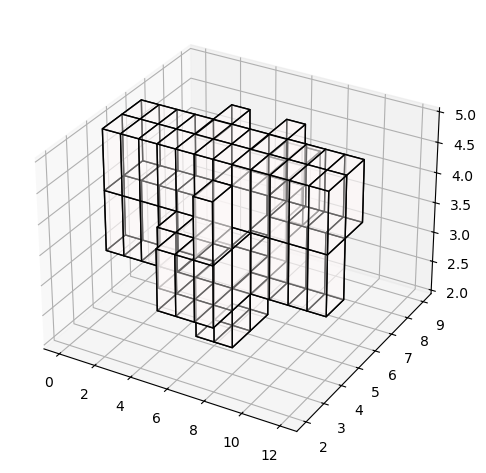

In [8]:
udp.plot('target', [2])

Plotting all three cube types gives us the ISS

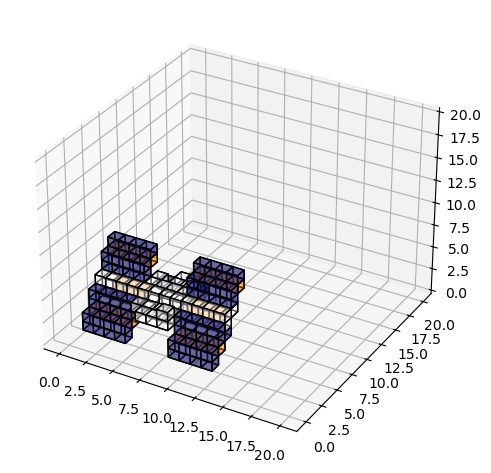

In [9]:
udp.plot('target', [0, 1, 2])

We can also plot the ensemble after applying the chromosome.

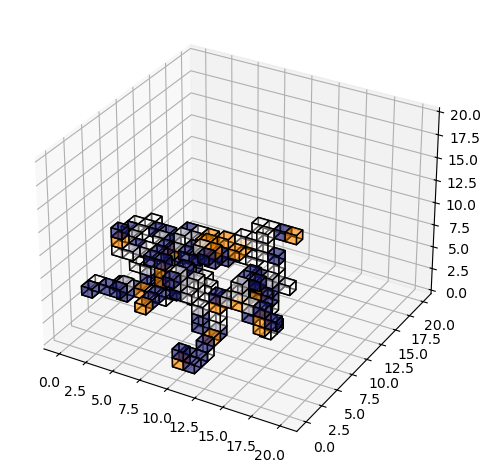

In [10]:
udp.plot('ensemble', [0, 1, 2])

After running the fitness function, the final cube positions can be accessed as follows. Note: re-running fitness overwrites this!

In [11]:
udp.final_cube_positions

array([[ 0,  3,  1],
       [ 5,  2,  4],
       [11,  6,  1],
       [ 0,  3,  5],
       [ 4,  5,  5],
       [12,  3,  2],
       [ 4,  5,  3],
       [ 2,  6,  4],
       [-1,  7,  5],
       [ 9,  7,  5],
       [ 7, -1, -1],
       [ 7, -1, -2],
       [ 9,  7,  7],
       [ 8,  3, -1],
       [ 3,  4,  3],
       [11,  6,  3],
       [ 0,  4,  3],
       [-1,  5,  5],
       [ 6,  3,  3],
       [ 7,  6,  7],
       [ 8,  1, -1],
       [12,  8,  8],
       [ 0,  2,  1],
       [ 3,  3,  1],
       [ 8,  1, -2],
       [10,  3,  3],
       [-1,  1,  2],
       [ 7,  4,  6],
       [11,  6,  4],
       [ 7,  3,  7],
       [11,  7,  6],
       [ 8,  3,  2],
       [-1,  3,  1],
       [ 8,  3,  1],
       [10,  7,  7],
       [ 8,  6,  6],
       [ 7,  4,  7],
       [ 6,  5,  7],
       [ 8,  4,  2],
       [10,  7,  1],
       [ 1,  4,  3],
       [ 0,  4,  5],
       [ 4,  7,  6],
       [ 5,  1,  5],
       [11,  6,  2],
       [-2,  7,  5],
       [ 9,  3,  3],
       [ 6,  

Cube types and target configuration are accessed as follows:

In [12]:
initial_types = udp.initial_cube_types
target_types = udp.target_cube_types
target_positions = udp.target_cube_positions

To plot the intial configuration, we use a chromosome which keeps the cube ensemble unchanged.

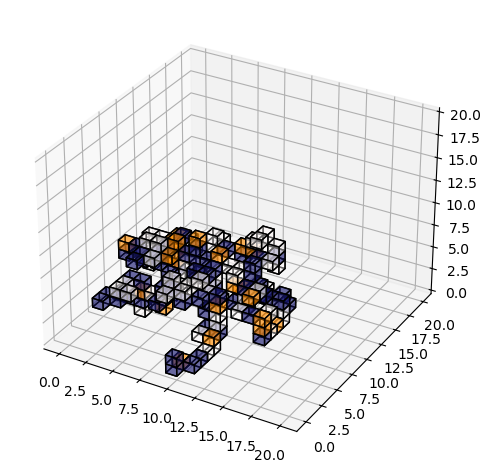

In [13]:
udp.fitness(np.array([-1]))
udp.plot('ensemble', [0, 1, 2])

#### In the previous example, lots of moves were actually not realisable

This can be seen by running the pretty function! Many of the cube/maneuver combinations would either disconnect the ensemble or the cube is physically not able to move / move without colliding with another cube.

In [14]:
udp.pretty(chromosome)

0 -- Cannot apply move 4 to cube 130. Cube would crash into neighbouring cubes. Skipping command...
2 -- Cannot apply move 4 to cube 46. Cube is connecting. Skipping command...
3 -- Cannot apply move 3 to cube 79. Cube is connecting. Skipping command...
5 -- Cannot apply move 3 to cube 61. Cube is connecting. Skipping command...
7 -- Cannot apply move 0 to cube 118. Cube is connecting. Skipping command...
8 -- Cannot apply move 3 to cube 75. Cube is connecting. Skipping command...
10 -- Cannot apply move 3 to cube 115. Cube is connecting. Skipping command...
12 -- Cannot apply move 3 to cube 23. Cube is connecting. Skipping command...
14 -- Cannot apply move 4 to cube 67. Cube is connecting. Skipping command...
15 -- Cannot apply move 0 to cube 55. Cube is connecting. Skipping command...
16 -- Cannot apply move 0 to cube 55. Cube is connecting. Skipping command...
17 -- Cannot apply move 2 to cube 53. Cube is connecting. Skipping command...
18 -- Cannot apply move 3 to cube 53. Cube is

The following functions removes these "illegal" moves!

In [15]:
# Function for removing illegal moves
def remove_illegal_moves_from_chromosome(chromosome):
    init = np.load('data/ISS/Initial_Config.npy')
    cubes = ProgrammableCubes(init)

    filtered_chromosome = []

    for i in range(int(len(chromosome)/2)):
        cube_id = chromosome[i*2]
        move = chromosome[i*2+1]
        done = cubes.apply_single_update_step(cube_id, move)
        # done is 1 if the move is legal and 0 otherwise
        if done == 1:
            filtered_chromosome += [cube_id, move]
    # The part to be evaluated by the fitness function ends here,
    # thus we add -1
    filtered_chromosome += [-1]
    
    # Fill up the remaining chromosome with 0s (will not be evaluated)
    if len(filtered_chromosome) < 12001:
        for i in range(12000 - len(filtered_chromosome)):
            filtered_chromosome += [0]
        # Mandatory entry of -1 at the very end
        filtered_chromosome += [-1]
        
    return np.array(filtered_chromosome)

# clean the chromosome!
cleaned_chromosome = remove_illegal_moves_from_chromosome(chromosome)

# and run it again!
udp = programmable_cubes_UDP('ISS')
prob = problem(udp)
prob.fitness(cleaned_chromosome)

array([0.0514562])

In [16]:
# plot the initial configuration
udp.plot('ensemble', [0, 1, 2])

AssertionError: 

The fitness improved because the evaluated part of the chromosome got shorter! Always remove unnecessary moves from your solution before submitting it!

#### However, we could also directly create a chromosome that only contains legal moves

This is slower though, as we have to go through the logic of checking moves!

In [17]:
# New function for creating a chromosome without illegal moves
def create_chromosome_with_legal_moves_only():
    init = np.load('data/ISS/Initial_Config.npy')
    cubes = ProgrammableCubes(init)

    chromosome = []

    while len(chromosome) < 12000:
        cube_id = np.random.randint(148)
        move = np.random.randint(6)
        done = cubes.apply_single_update_step(cube_id, move)
        if done == 1:
            chromosome += [cube_id, move]
    chromosome += [-1]
        
    return np.array(chromosome)
    
# create your chromosome
full_chrom = create_chromosome_with_legal_moves_only()

# and run it!
udp = programmable_cubes_UDP('ISS')
prob = problem(udp)
prob.fitness(full_chrom)

array([0.10670194])

In [18]:
udp.plot('ensemble', [0, 1, 2])

AssertionError: 

#### If you like, you can also animate your solution :)

In [16]:
# Lets load the initial data
init = np.load('data/ISS/Initial_Config.npy')
cube_types = np.load('data/ISS/Initial_Cube_Types.npy')
cubes = ProgrammableCubes(deepcopy(init))

# Function to turn the sparse cube representation into a dense one (for plotting only)
def coords_to_dense(positions, cube_types):
    cube_tensor = np.zeros((3, 30,30,30))
    for l in range(len(cube_types)):
        for pos in positions[cube_types == l]:
            i,j,k = pos
            cube_tensor[l][i+10][j+10][k+10] = 1
    return cube_tensor

# store cube configs to be plotted
storage = [coords_to_dense(cubes.cube_position, cube_types)]

# apply moves and store results for plotting
steps = 0
tobreak = False
for j in range(int(len(cleaned_chromosome)/2)):
    cube_id = cleaned_chromosome[2*j]
    move = cleaned_chromosome[2*j+1]
    if cube_id == -1:
        break
    done = cubes.apply_single_update_step(cube_id, move, verbose=True)
    steps += done
    storage.append(coords_to_dense(cubes.cube_position, cube_types))

Lets go!

MovieWriter ffmpeg unavailable; using Pillow instead.


IndexError: list index out of range

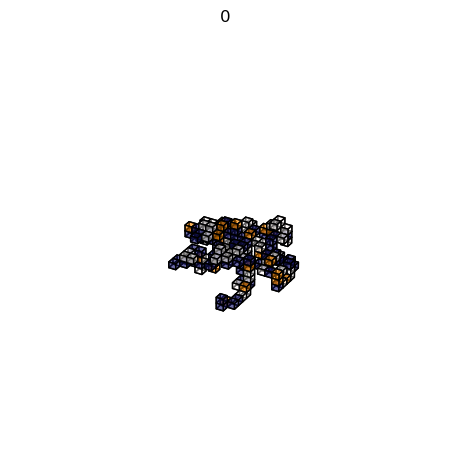

In [17]:
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.bbox'] = 'tight'
with open('problems/ISS.json') as infile:
    colours = json.load(infile)['colours']


fig = plt.figure(figsize=(plt.figaspect(1)))
ax = fig.add_subplot(1, 1, 1, projection='3d')
sns.despine(ax=ax, bottom=True,top=True,left=True,right=True)
ln, = ax.plot3D([0], [0], [0])
ax._axis3don = False
ax.set_facecolor('white')
        
def init():
    return ln,

def update(kk):
    ax.clear()
    for l in range(3):
        ax.voxels(storage[kk][l], facecolor = colours[l], edgecolors = 'k', alpha=.4)
    ax.axis('off')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.set_title('{}'.format(kk))
    ax._axis3don = False
    plt.tight_layout()

# to speed it up, we only show the ensemble after each 100th move. 
# Choose a smaller number than 100 to show more intermediate moves!
ani = FuncAnimation(fig, update, frames=np.arange(0,len(storage),100),
                    init_func=init, interval=1000., blit=True)
ani.save('ISS.gif')

#### Also: you might not always want to start from the beginning to speed things up!

You can start evaluation from a custom configuration instead! For instance, here we start from the target configuration (although cube types do not match, so the fitness can still be improved!):

In [19]:
udp.fitness(np.array([-1]), initial_configuration=udp.target_cube_positions)

[np.float64(-0.23015873015873012)]

### Now lets do the same for James Webb!

In [20]:
def create_random_chromosome():
    chrom = []
    for i in range(30000):
        cube_id = np.random.randint(643)
        move = np.random.randint(6)

        chrom += [cube_id, move]
    chrom += [-1]
    return np.array(chrom)

chromosome = create_random_chromosome()

udp = programmable_cubes_UDP('JWST')
prob = problem(udp)
prob.fitness(chromosome)

array([0.16888889])

<IPython.core.display.Javascript object>


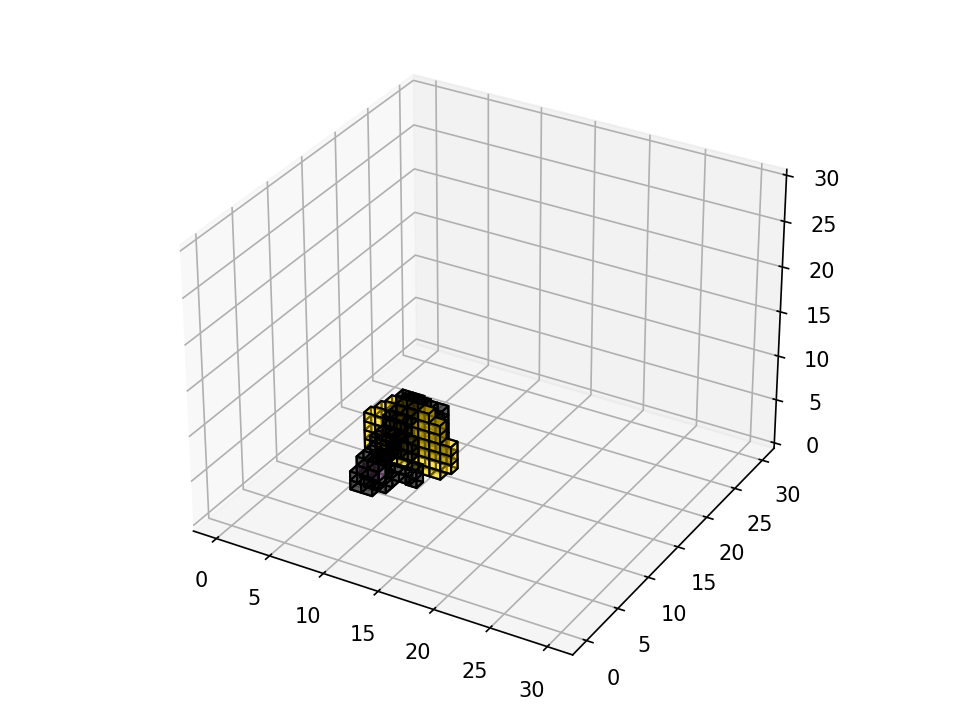

In [16]:
udp.fitness(chromosome)
udp.plot('target', [3,4,5])

<IPython.core.display.Javascript object>


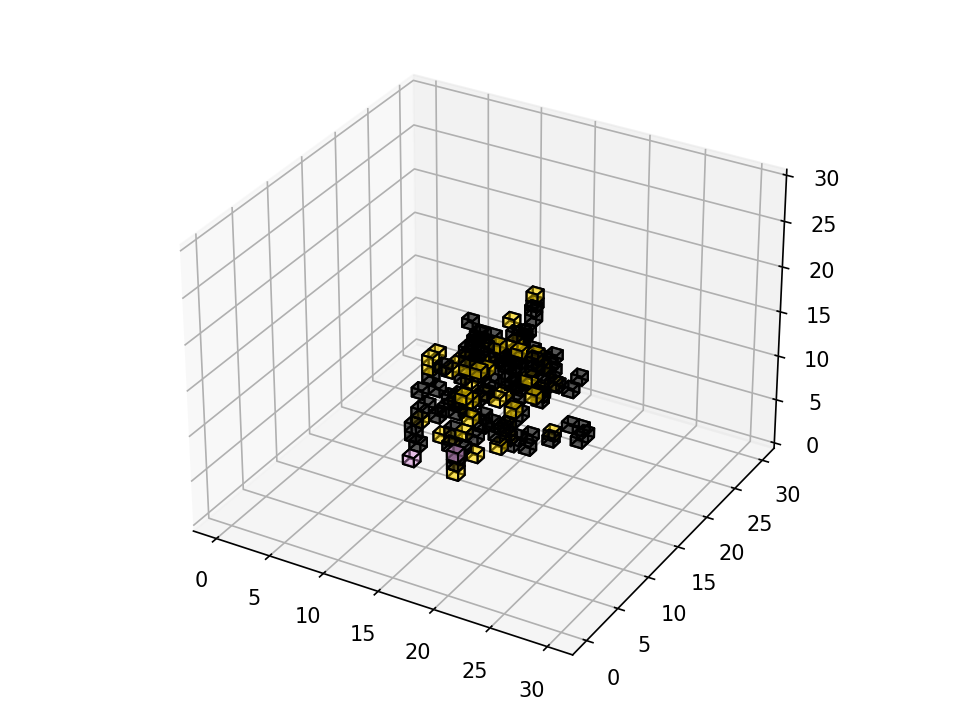

In [17]:
udp.plot('ensemble', [3,4,5])

### And for the Enterprise!

In [18]:
def create_random_chromosome():
    chrom = []
    for i in range(100000):
        cube_id = np.random.randint(1472)
        move = np.random.randint(6)

        chrom += [cube_id, move]
    chrom += [-1]
    return np.array(chrom)

chromosome = create_random_chromosome()

udp = programmable_cubes_UDP('Enterprise')

<IPython.core.display.Javascript object>


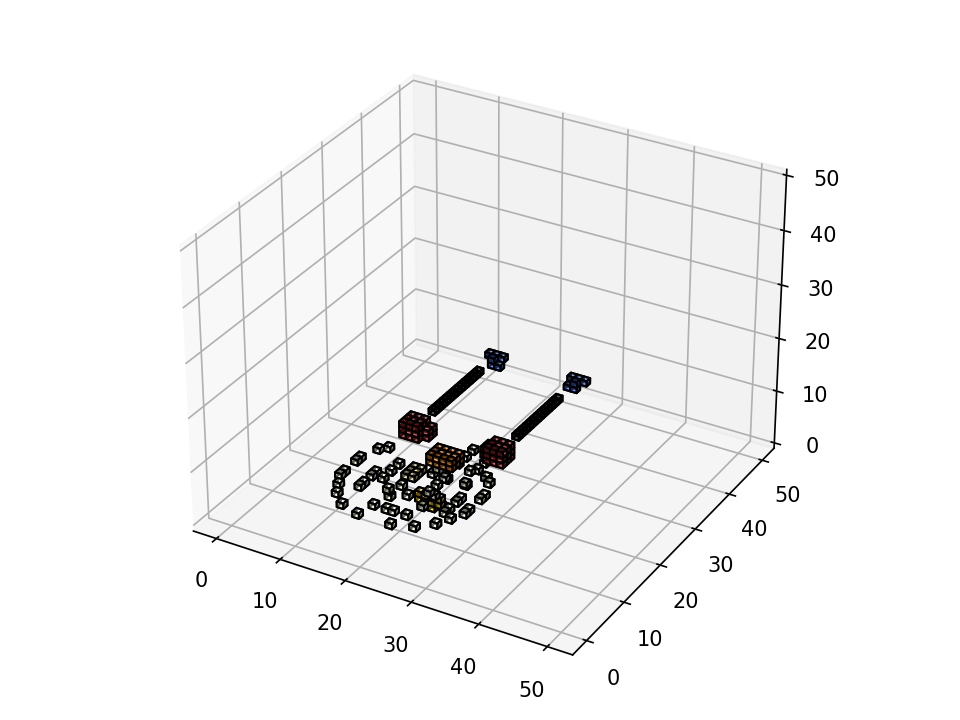

In [19]:
udp.fitness(np.array([-1]))
udp.plot('target', [1,2,3,5,6,7,8,9])

<IPython.core.display.Javascript object>


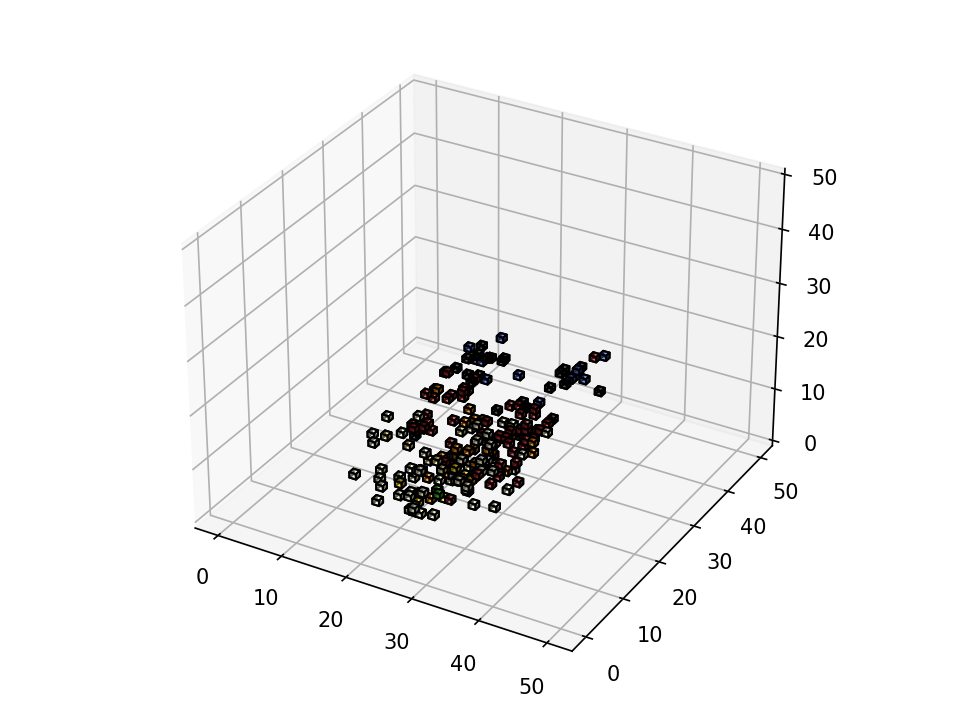

In [20]:
udp.plot('ensemble', [1,2,3,5,6,7,8,9])

##### Now you know the basics :) Good luck and have fun!!